# Introduction (Identifying the Business Problem)

Toronto is one of the populated areas in Canada with an estimated population of over 6 million people. This brings opportunities for entrepreneurs to start or grow their business. Toronto is well known for its food

The objective of this project is to use Foursquare location data and clustering of venue information to determine what might be the ‘best’ neighbourhood in Toronto to open a restaurant. Pizza and Pasta are one of the most bought dishes in Toronto originating from Italy. Toronto is the fourth largest home to Italians with a population of over 500k, there are numerous opportunities to open a new Italian restaurant. Through this project, we will find the most suitable location for an entrepreneur to open a new Italian restaurant in Toronto, Canada.


# Target Audience

This project is aimed towards Entrepreneurs or Business owners who want to open a new Italian Restaurant or grow their current business. The analysis will provide insights that can be used by these Entrepreneurs or Business owners

# Data

1.[Toronto Neighbourhood Data in Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)<br>
2.[CSV file link](https://cocl.us/Geospatial_data)<br>
3.Venue Data using FourSquare<br>

## Data Cleaning

In [1]:
# Import libraries
import pandas as pd
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
df = pd.read_html(url)
df = df[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
# Drop all the Not assigned in Borough
df = df.loc[df['Borough']!='Not assigned']

# Check for duplicated
dup = df['Postal Code'].duplicated().any()
print('Duplicated Postal Code:',dup)

# Check if there is any neighbourhood not assigned
df.loc[df['Neighbourhood']=='Not assigned']

Duplicated Postal Code: False


,Postal Code,Borough,Neighbourhood


In [5]:
print(df.shape)
df.head()

(103, 3)


,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


**Read Geospatial Coordinates from CSV and merge**

In [6]:
geo_df = pd.read_csv('Geospatial_Coordinates.csv')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
df_merged = df.merge(geo_df,left_on='Postal Code',right_on='Postal Code')
df_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [8]:
# Let's find out how many Neighbourhood in each Borough
df_merged.groupby(['Borough']).count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

In [9]:
Borough = df_merged['Borough'].unique().tolist()

**Obtain coordinates of Toronto by averaging Latitude and Longtitude from dataset**

In [10]:
lat_toronto = df_merged['Latitude'].mean()
lon_toronto = df_merged['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.704607733980595, -79.3971529116505


In [11]:
borough_color = {}
for borough in Borough:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

**Visualize data using folium**

In [12]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], 
                                           df_merged['Longitude'],
                                           df_merged['Borough'], 
                                           df_merged['Neighbourhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

**Define FourSquare Credentials**

In [13]:
CLIENT_ID = 'MYEJ254LOAKXKTL1GM3OESCIQPBBWVCSIUIS345IVWZDFQIN' # your Foursquare ID
CLIENT_SECRET = 'OCAPGCL3NIG55023NV4NOQCUQ2DD0HUVKQRN2JZBVXWGG5PQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

**Get top 100 venues within radius of 500 metres**

In [14]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_merged['Neighbourhood'],
                                latitudes=df_merged['Latitude'],
                                longitudes=df_merged['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [16]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [17]:
# Checking how many values per neighbourhood
toronto_venues.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",6,6,6,6,6,6
Woburn,4,4,4,4,4,4


**Checking Unique Venues**

In [18]:
Venue_Cat = toronto_venues['Venue Category'].unique()
Venue_Cat

array(['Park', 'Food & Drink Shop', 'Construction & Landscaping',
       'Hockey Arena', 'Portuguese Restaurant', 'Coffee Shop',
       'French Restaurant', 'Intersection', 'Pizza Place', 'Bakery',
       'Distribution Center', 'Spa', 'Restaurant', 'Pub',
       'Breakfast Spot', 'Gym / Fitness Center', 'Historic Site',
       'Farmers Market', 'Dessert Shop', 'Chocolate Shop',
       'Performing Arts Venue', 'Mexican Restaurant', 'Café',
       'Yoga Studio', 'Theater', 'Event Space', 'Asian Restaurant',
       'Shoe Store', 'Ice Cream Shop', 'Electronics Store', 'Art Gallery',
       'Bank', 'Beer Store', 'Hotel', 'Health Food Store', 'Antique Shop',
       'Boutique', 'Furniture / Home Store', 'Vietnamese Restaurant',
       'Clothing Store', 'Accessories Store', 'Miscellaneous Shop',
       'Italian Restaurant', 'Creperie', 'Sushi Restaurant',
       'Arts & Crafts Store', 'Burrito Place', 'Beer Bar', 'Hobby Shop',
       'Diner', 'Fried Chicken Joint', 'Smoothie Shop', 'Sandwich P

In [19]:
print('There are',len(Venue_Cat), 'unique categories')

There are 269 unique categories


In [20]:
# Check if there is any Italian Restaurant
'Italian Restaurant' in Venue_Cat

True

In [21]:
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
to_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2141, 270)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [23]:
grouped_df = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(grouped_df.shape)
grouped_df.head()

(96, 270)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
italian_df = grouped_df[['Neighborhoods','Italian Restaurant']]
italian_df.head()

,Neighborhoods,Italian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.086957


# Machine Learning

**Clustering the Neighbourhoods using K-means clustering. We will find the best K using elbow point method**

In [25]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = italian_df.drop(['Neighborhoods'], axis=1)

In [26]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [27]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [28]:
scores = [get_inertia(x) for x in range(2, 21)]

**From the plot, the elbow is at 4, we will use K = 4**

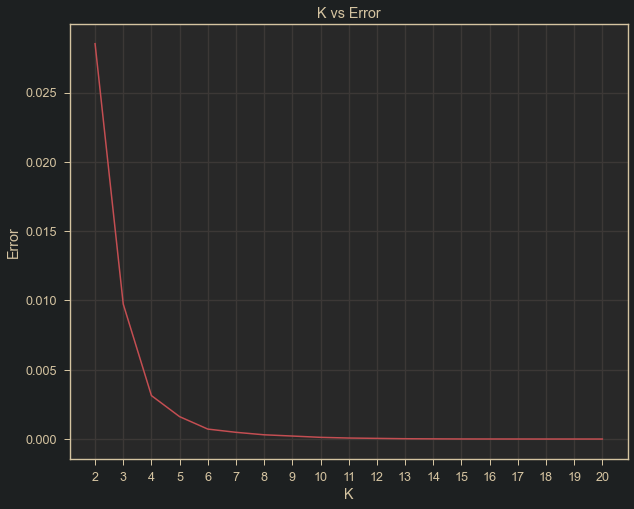

In [29]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")
plt.grid()
plt.show()

In [30]:
kclusters = 4

toronto_grouped_clustering = italian_df.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 3, 0, 3, 0, 0])

In [31]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
clus_merged = italian_df.copy()

# add clustering labels
clus_merged["Cluster Labels"] = kmeans.labels_

In [32]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
clus_merged = clus_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhoods")

print(clus_merged.shape)
clus_merged.head()

(2141, 9)


,Neighborhoods,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.794200,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
1,"Alderwood, Long Branch",0.0,0,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place


In [33]:
# sort the results by Cluster Labels
clus_merged.sort_values(["Cluster Labels"], inplace=True)
clus_merged

,Neighborhoods,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.00,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
47,Leaside,0.00,0,43.709060,-79.363452,Local Leaside,43.710012,-79.363514,Sports Bar
46,Lawrence Park,0.00,0,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
46,Lawrence Park,0.00,0,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
46,Lawrence Park,0.00,0,43.728020,-79.388790,The Photo School – Toronto,43.730429,-79.388767,Photography Studio
...,...,...,...,...,...,...,...,...,...
36,"High Park, The Junction South",0.04,3,43.661608,-79.464763,Lithuania Park,43.658667,-79.463038,Park
35,"Harbourfront East, Union Station, Toronto Islands",0.02,3,43.640816,-79.381752,Starbucks,43.640990,-79.376264,Coffee Shop
35,"Harbourfront East, Union Station, Toronto Islands",0.02,3,43.640816,-79.381752,Tim Hortons,43.638828,-79.380373,Coffee Shop
35,"Harbourfront East, Union Station, Toronto Islands",0.02,3,43.640816,-79.381752,Jays Shop Stadium Edition,43.641721,-79.387127,Sporting Goods Shop


In [34]:
clus_merged['Venue Category'].value_counts()['Italian Restaurant']

45

In [35]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clus_merged['Neighborhood Latitude'], clus_merged['Neighborhood Longitude'], clus_merged['Neighborhoods'], clus_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [36]:
italian_df['Cluster Labels'] = kmeans.labels_
italian_df.head()

<ipython-input-36-44c8a75918b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  italian_df['Cluster Labels'] = kmeans.labels_


,Neighborhoods,Italian Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.086957,1


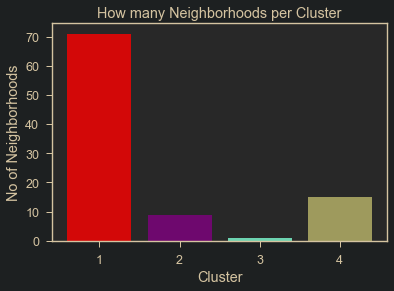

In [37]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = italian_df['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [38]:
italian_df['Cluster Labels'].value_counts()

0    71
3    15
1     9
2     1
Name: Cluster Labels, dtype: int64

# Analysis of each cluster

**Cluster 1**

In [39]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighbourhood']]
df_new.head()

,Borough,Neighbourhood
2,North York,Parkwoods
3,North York,Victoria Village
4,Downtown Toronto,"Regent Park, Harbourfront"
5,North York,"Lawrence Manor, Lawrence Heights"
6,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [40]:
clus_merged = clus_merged.rename(columns={'Neighborhoods':'Neighbourhood'})

In [41]:
# Red 
cluster1 = clus_merged.loc[clus_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighbourhood')
df_cluster1

,Borough,Neighbourhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,0.0,0,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,North York,Parkwoods,0.0,0,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
2,North York,Parkwoods,0.0,0,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,North York,Victoria Village,0.0,0,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
4,North York,Victoria Village,0.0,0,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
...,...,...,...,...,...,...,...,...,...,...
1002,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",0.0,0,43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym
1003,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",0.0,0,43.628841,-79.520999,Once Upon A Child,43.631075,-79.518290,Kids Store
1004,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",0.0,0,43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
1005,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",0.0,0,43.628841,-79.520999,Islington Florist & Nursery,43.630156,-79.518718,Flower Shop


**Cluster 2**

In [42]:
# Purple
cluster2 = clus_merged.loc[clus_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighbourhood')
df_cluster2

,Borough,Neighbourhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,JOEY Eaton Centre,43.656094,-79.381878,New American Restaurant
1,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,Panago,43.658258,-79.384313,Pizza Place
2,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,The Queen and Beaver Public House,43.657472,-79.383524,Gastropub
3,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,The Elm Tree Restaurant,43.657397,-79.383761,Modern European Restaurant
4,Downtown Toronto,Central Bay Street,0.0625,1,43.657952,-79.387383,KAKA,43.657457,-79.384192,Japanese Restaurant
...,...,...,...,...,...,...,...,...,...,...
253,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",0.1000,1,43.781638,-79.304302,Petro-Canada,43.779337,-79.307682,Gas Station
254,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",0.1000,1,43.781638,-79.304302,KFC,43.780400,-79.300700,Fast Food Restaurant
255,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",0.1000,1,43.781638,-79.304302,Popeyes Louisiana Kitchen,43.780476,-79.298460,Fried Chicken Joint
256,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",0.1000,1,43.781638,-79.304302,Little Caesars Pizza,43.780563,-79.298624,Pizza Place


**Cluster 3**

In [43]:
# Blue
cluster3 = clus_merged.loc[clus_merged['Cluster Labels'] == 3]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighbourhood')
df_cluster3

,Borough,Neighbourhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.029412,3,43.662301,-79.389494,Como En Casa,43.665160,-79.384796,Mexican Restaurant
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.029412,3,43.662301,-79.389494,401 Games,43.663623,-79.384037,Hobby Shop
2,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.029412,3,43.662301,-79.389494,Coach House Restaurant,43.664991,-79.384814,Diner
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.029412,3,43.662301,-79.389494,Hart House Theatre,43.663571,-79.394616,Theater
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.029412,3,43.662301,-79.389494,Flock Rotisserie + Greens,43.659167,-79.389475,Fried Chicken Joint
...,...,...,...,...,...,...,...,...,...,...
941,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,3,43.667967,-79.367675,TD Canada Trust,43.664655,-79.367887,Bank
942,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,3,43.667967,-79.367675,Thai Room - Carlton,43.664159,-79.368189,Thai Restaurant
943,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,3,43.667967,-79.367675,Winchester Park,43.666231,-79.371631,Playground
944,Downtown Toronto,"St. James Town, Cabbagetown",0.041667,3,43.667967,-79.367675,LCBO,43.665586,-79.368531,Liquor Store


**Cluster 4**

In [44]:
# Turquoise
cluster4 = clus_merged.loc[clus_merged['Cluster Labels'] == 4]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighbourhood')
df_cluster4

,Borough,Neighbourhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


*Cluster 1*

In [54]:
len(cluster1['Neighbourhood'].unique())

71

In [55]:
cluster1.loc[cluster1['Venue Category']=='Italian Restaurant']

,Neighbourhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
29,"First Canadian Place, Underground city",0.01,0,43.648429,-79.38228,Mercatto,43.650243,-79.38082,Italian Restaurant


*Cluster 2*

In [56]:
len(cluster2['Neighbourhood'].unique())

9

In [59]:
cluster2.loc[cluster2['Venue Category']=='Italian Restaurant']

,Neighbourhood,Italian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
68,"Runnymede, Swansea",0.055556,1,43.651571,-79.484450,Goodfellas Wood Oven Pizza,43.648224,-79.486356,Italian Restaurant
13,Central Bay Street,0.062500,1,43.657952,-79.387383,Mercatto,43.660391,-79.387664,Italian Restaurant
13,Central Bay Street,0.062500,1,43.657952,-79.387383,Scaddabush Italian Kitchen & Bar,43.658920,-79.382891,Italian Restaurant
13,Central Bay Street,0.062500,1,43.657952,-79.387383,Sambuca Grill,43.656110,-79.392946,Italian Restaurant
59,"Parkdale, Roncesvalles",0.071429,1,43.648960,-79.456325,Domani Restaurant & Wine Bar,43.649235,-79.450229,Italian Restaurant
16,"Clarks Corners, Tam O'Shanter, Sullivan",0.100000,1,43.781638,-79.304302,Remezzo Italian Bistro,43.778649,-79.308264,Italian Restaurant
13,Central Bay Street,0.062500,1,43.657952,-79.387383,Tosto,43.661198,-79.386414,Italian Restaurant
14,Christie,0.062500,1,43.669542,-79.422564,Vinny’s Panini,43.670679,-79.426148,Italian Restaurant
80,"The Danforth West, Riverdale",0.071429,1,43.679557,-79.352188,IL FORNELLO on Danforth,43.678604,-79.346904,Italian Restaurant
4,"Bedford Park, Lawrence Manor East",0.086957,1,43.733283,-79.419750,Francobollo,43.734557,-79.419549,Italian Restaurant


In [60]:
cluster2.loc[cluster2['Venue Category']=='Italian Restaurant'].count()

Neighbourhood             17
Italian Restaurant        17
Cluster Labels            17
Neighborhood Latitude     17
Neighborhood Longitude    17
Venue                     17
Venue Latitude            17
Venue Longitude           17
Venue Category            17
dtype: int64

*Cluster 3*

In [61]:
len(cluster3['Neighbourhood'].unique())

15

In [62]:
cluster3.loc[cluster3['Venue Category']=='Italian Restaurant'].count()

Neighbourhood             26
Italian Restaurant        26
Cluster Labels            26
Neighborhood Latitude     26
Neighborhood Longitude    26
Venue                     26
Venue Latitude            26
Venue Longitude           26
Venue Category            26
dtype: int64

*Cluster 4*

In [63]:
len(cluster4['Neighbourhood'].unique())

0

In [64]:
cluster4.loc[cluster4['Venue Category']=='Italian Restaurant'].count()

Neighbourhood             0
Italian Restaurant        0
Cluster Labels            0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
dtype: int64

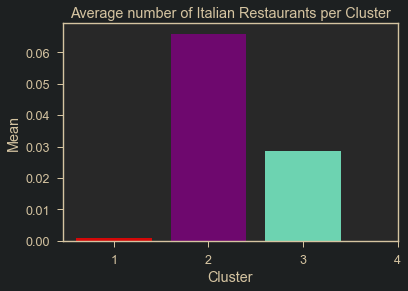

In [45]:
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                 df_cluster4['Italian Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

plt.show()

# Conclusion

Most of the Italian restaurants are located in cluster 3 represented by the blue circles. We know that Cluster 4 has no neighbourhoods and no Italian restaurants. Looking at all of the clusters, the most appropriate cluster to put a new Italian restaurant is in cluster 1 as it has 71 neighbourhoods but only 1 Italian restaurant, therefore eliminating any competition. Some drawbacks of this analysis are clustering based on data obtain from Foursquare API and also does not consider the population across the neighbourhoods which will affect the business of the new Italian restaurant